In [140]:
#IMPORTS
import pm4py
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
from itertools import product

# Prepare the Data
The code below is used to generate the CVS file. You can also skip running it and instead load the CSV directly a few cells below.

First, make sure the permit log is in the current directory, then run the code below

In [2]:
travel_permits = pm4py.read_xes('PermitLog.xes.gz')

parsing log, completed traces ::   0%|          | 0/7065 [00:00<?, ?it/s]

First, we make sure we have the prefixes we need, we just want the events leading up to 'Start trip'

In [142]:
travel_prefixes = pm4py.filtering.filter_prefixes(travel_permits, 'Start trip')

In [9]:
#quick check to see if we got what we wanted
i = 39
for e in travel_permits[i]:
    print(e['concept:name'])
print() 
for e in travel_prefixes[i]:
    print(e['concept:name'])

Permit SUBMITTED by EMPLOYEE
Permit FINAL_APPROVED by SUPERVISOR
Start trip
End trip
Declaration SUBMITTED by EMPLOYEE
Declaration FINAL_APPROVED by SUPERVISOR
Request Payment
Payment Handled

Permit SUBMITTED by EMPLOYEE
Permit FINAL_APPROVED by SUPERVISOR


Check if a declaration was submitted before the trip started

In [51]:
decl_bools = np.zeros((7065,1))

for i,t in enumerate(travel_prefixes):
    for e in t:
        if e['concept:name'] == "Declaration SUBMITTED by EMPLOYEE":
            decl_bools[i,0] = 1
            
decl_bools.shape

(7065, 1)

Now extract the features we are interested in from the prefixes:

In [125]:
data_regr, _ = log_to_features.apply(travel_prefixes, parameters={'num_tr_attr': ["RequestedBudget","OverspentAmount"]})
data_class, _ = log_to_features.apply(travel_prefixes, parameters={'num_tr_attr': ["RequestedBudget","Overspent"]})

data_regre = np.array(data_regr).round(2)
data_class = np.array(data_class).round(2)
data_class.shape

(7065, 2)

However, we still need trip duration, which we will need to compute manually. We will use number of days to denote the duration

In [52]:
trip_durations = []
for trace in travel_permits:
    for e in trace:
        if e['concept:name'] == "Start trip": #note the time the trip started
            start_time = e['time:timestamp']
        elif e['concept:name'] == "End trip": #note the time the trip ended
            end_time = e['time:timestamp']
            break
    trip_durations.append((end_time-start_time).days) #save the trip duration in days
    
trip_durations = np.array(trip_durations).reshape((-1,1))
trip_durations.shape

(7065, 1)

And we do the same in order to get the duration between the permit being submitted and the permit being approved

In [53]:
perm_durations = []
for trace in travel_permits:
    started = False
    for e in trace:
        if e['concept:name'].startswith("Permit") and not started: #start time is the first time permit is mentioned
            started = True
            start_time = e['time:timestamp']
            end_time = e['time:timestamp']
        elif e['concept:name'].startswith("Permit"): #end time is the last time permit is mentioned
            end_time = e['time:timestamp']
    perm_durations.append((end_time-start_time).days) #save duration of permit handling in days
    
perm_durations = np.array(perm_durations).reshape((-1,1))
perm_durations.shape

(7065, 1)

Now we merge all the features we extracted into one dataframe

In [126]:
final_data_regr = np.absolute(np.concatenate((decl_bools, trip_durations, perm_durations, data_regr), axis=1))
final_data_class = np.concatenate((decl_bools, trip_durations, perm_durations, data_class), axis=1)
final_data_class.shape

(7065, 5)

Some exploration of the data we have now:

In [129]:
pd.DataFrame(data=final_data_class[:10,:])

,0,1,2,3,4
0,0.0,0.0,0.0,41.61,0.0
1,0.0,31.0,0.0,795.54,0.0
2,0.0,0.0,0.0,51.79,1.0
3,0.0,21.0,0.0,0.00,0.0
4,0.0,364.0,0.0,6020.79,0.0
5,0.0,2.0,0.0,245.06,0.0
6,0.0,6.0,0.0,0.00,0.0
7,0.0,3.0,0.0,1015.98,0.0
8,0.0,5.0,0.0,0.00,0.0
9,0.0,5.0,0.0,156.96,0.0


We can now save the data to CSV:

In [130]:
np.savetxt('ML_data_class.csv', final_data_class, delimiter=',')
np.savetxt('ML_data_regr.csv', final_data_regr, delimiter=',')

# Load the CSV
Or skip the below cell if you already ran the above cells

In [131]:
final_data_class = np.genfromtxt('ML_data_class.csv',delimiter=',')
final_data_regr = np.genfromtxt('ML_data_regr.csv',delimiter=',')
final_data_regr.shape

(7065, 5)

# Train the ML model

## Regression
First, we split into train, test and validation sets. We do not shuffle because for process mining it is important that the validation and test sets are further in the future than the training set. The training set is 50%, validation 25%, and test set 25%.

In [132]:
X_train, X_valtest, y_train, y_valtest = sklearn.model_selection.train_test_split(final_data_regr[:,:-1], final_data_regr[:,-1], 
                                                                                  train_size=0.5, shuffle=False)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_valtest, y_valtest, train_size=0.5, shuffle=False)

Next, we do a parameter search and choose the best parameters based on performance on the validation set. The score metric here has a maximum value of 1.0 and no minimum value.

In [133]:
#no gridsearchcv because it doesn't allow for a validation set
best_score = -10000
for n_est, min_split in product([25,50,100,200], [1,20,50]): #parameter search on 'n_estimators' and 'min_samples_split'
    model = RandomForestRegressor(n_estimators = n_est, min_samples_split = min_split)
    model.fit(X_train, y_train)
    score = model.score(X_val, y_val)
    print("n_estimators: {}, min_samples_split: {}, score: {}".format(n_est, min_split, score))
    if score > best_score:
        best_score = score
        best_param = n_est, min_split

n_estimators: 25, min_samples_split: 1, score: -0.0007196810568610434
n_estimators: 25, min_samples_split: 20, score: -0.00023183243172675283
n_estimators: 25, min_samples_split: 50, score: 3.311033806752128e-05
n_estimators: 50, min_samples_split: 1, score: -0.0004588330093315829
n_estimators: 50, min_samples_split: 20, score: -6.448924663549072e-05
n_estimators: 50, min_samples_split: 50, score: 0.00013473319769718994
n_estimators: 100, min_samples_split: 1, score: -0.0005002573727634907
n_estimators: 100, min_samples_split: 20, score: -0.00022874689195417908
n_estimators: 100, min_samples_split: 50, score: 0.0002416367323141433
n_estimators: 200, min_samples_split: 1, score: -0.0005446518479892415
n_estimators: 200, min_samples_split: 20, score: -0.00017387305783267415
n_estimators: 200, min_samples_split: 50, score: 6.686392499044569e-05


Now we take the model with the best performing parameters and test its performance on the test set

In [134]:
best_model = RandomForestRegressor(n_estimators = best_param[0], min_samples_split = best_param[1])
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)

0.31351903378083057

This score metric isn't the most intuitive, so let's compute mean absolute error on the test set as well.

In [135]:
mean_absolute_error(y_test, best_model.predict(X_test))

411.5780501683343

We can plot the predicted values against the true values in order to visualize how well the model performs

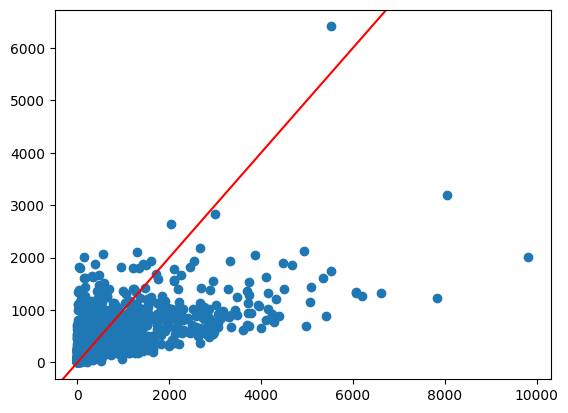

In [136]:
plt.figure(0)
plt.scatter(y_test, best_model.predict(X_test))
plt.axline((0,0), slope=1, c='r')

We can also compare the model to a naive predictor, like simply taking the average of overspent amount

In [137]:
average_train_overspent = np.mean(y_train)
y_predict_test = np.full(1767, average_train_overspent)
mean_absolute_error(y_test, y_predict_test)

556.3749265488983

In [138]:
r2_score(y_test, y_predict_test)

-0.011135315589121841

## Classification
We again start by dividing everything into train, validation and test sets.

In [139]:
X_train, X_valtest, y_train, y_valtest = sklearn.model_selection.train_test_split(final_data_class[:,:-1], final_data_class[:,-1], 
                                                                                  train_size=0.5, shuffle=False)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_valtest, y_valtest, train_size=0.5, shuffle=False)

Once again we do a parameter search to find the best hyperparameters, using the validation set.

In [141]:
best_score = -10000
for n_est, min_split in product([25,50,100,200], [1,20,50]): #parameter search on 'n_estimators' and 'min_samples_split'
    model = RandomForestClassifier(n_estimators = n_est, min_samples_split = min_split)
    model.fit(X_train, y_train)
    score = model.score(X_val, y_val)
    print("n_estimators: {}, min_samples_split: {}, score: {}".format(n_est, min_split, score))
    if score > best_score:
        best_score = score
        best_param = n_est, min_split

n_estimators: 25, min_samples_split: 1, score: 0.6268403171007928
n_estimators: 25, min_samples_split: 20, score: 0.6681766704416761
n_estimators: 25, min_samples_split: 50, score: 0.6828992072480181
n_estimators: 50, min_samples_split: 1, score: 0.6172140430351076
n_estimators: 50, min_samples_split: 20, score: 0.6710079275198187
n_estimators: 50, min_samples_split: 50, score: 0.6845979614949037
n_estimators: 100, min_samples_split: 1, score: 0.6206115515288788
n_estimators: 100, min_samples_split: 20, score: 0.6710079275198187
n_estimators: 100, min_samples_split: 50, score: 0.6834654586636466
n_estimators: 200, min_samples_split: 1, score: 0.6194790486976217
n_estimators: 200, min_samples_split: 20, score: 0.67440543601359
n_estimators: 200, min_samples_split: 50, score: 0.6845979614949037


In [143]:
best_model = RandomForestClassifier(n_estimators = best_param[0], min_samples_split = best_param[1])
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)

0.7843803056027164

Once again we compare to a naive model, this time simply the most common class.

In [149]:
most_common_class = np.bincount(y_test.astype(int)).argmax()

0